In [5]:
%run "RBM.ipynb"

class Classification_Generation(RBM):
    # n_k is the number of classes
    def __init__(self, n_x, n_h, n_k, n_d=1, W=None, b=None, c=None, k=1):
        super().__init__(n_x+n_k*n_d, n_h, W=None, b=None, c=None, k=1)
        self.n_x = n_x
        self.n_k = n_k
        self.n_d = n_d  
        # label is represented with n_k*n_d dots, where label i is the i-th group of n_d dots
        # np.zeros(n_k*n_d)[i*n_d:+n_d] = 1
        return
        
    def convert_input(self, X, Label):
        n_sample = X.shape[0]
        n_k = self.n_k; n_d = self.n_d; n_x = self.n_x
        assert X.shape == (n_sample, n_x)

        if Label is not None:
            Label = Label.flatten()
            #attach label to data
            Y = np.zeros(shape=(n_sample, n_k))
            Index = np.arange(n_sample)
            Y[Index, Label] = 1
            Y = Y.repeat(n_d, axis=1)
        else:
            Y = np.zeros(shape=(n_sample, n_k*n_d))

        V = np.append(X, Y, axis=1)
        assert V.shape == (n_sample, self.n_v)        
        return V

    def train(self, X, Label, learning=0.01):
        V = self.convert_input(X, Label)
        self.contrastive_divergence(V, learning)
        return
        

    def classify(self, x):
        #set_trace()
        x = x.reshape(1,-1)
        v = self.convert_input(x, None)
        vp, vs = self.reconstruct(v)

        n_k = self.n_k; n_d = self.n_d; n_x = self.n_x
        result = vp[0, n_x:]
        result = result.reshape(n_k, -1).sum(axis=1) # collapse the k*d dots into k sum dots.
        pred = np.argmax(result)

        return vp[0, :n_x], pred
    
    def generate(self, label, k_cd, init_w, w):
        # this is a very simple generation algorithm with single-layer RBM
        n_x = self.n_x; n_k = self.n_k; n_d = self.n_d

        classes = np.zeros(n_k)
        classes[label] = init_w
        classes = classes.repeat(n_d)
        
        np.random.seed(1234)
    #    v = np.append( np.random.binomial(1, 0.5, n_x), classes)
    #    v = np.append( np.zeros(n_x), classes)
        v = np.append( np.random.uniform(0, 0.8, n_x), classes)
        vp = v.reshape(1,-1)

        classes = np.zeros(n_k)
        classes[label] = w
        classes = classes.repeat(n_d)

        for i in range(k_cd):
            vp, vs = self.reconstruct(vp)
            vp[0, n_x:] = classes

        return vp[0, :n_x]
            

In [6]:
# testing of the RBM Classification_Generation code above

%run "mnist.ipynb"
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import Grid
import math

class MNIST_RBM:
    def __init__(self, folder="../convolution-network"):
        self.train_input = MnistInput("train", folder)
        self.test_input = MnistInput("test", folder)
        d = 28
        n_x = d*d; n_h = d*3+1; n_k = 10; n_d = 1
        self.rbm = Classification_Generation(n_x, n_h, n_k, n_d)
        return

    def train(self, train_size=-1, n_epoch=100, batch_size=10, learning=0.1):
        n_ep = 0
        n_sample = 0 
        X = []
        Y = []
        batch_size = batch_size if batch_size > 0 else 100
        n_epoch = n_epoch if n_epoch > 0 else 1
        startrate = learning
        for i in range(n_epoch):
            learning = startrate * math.pow(0.1, i//50) 
            for x, y in self.train_input.read(train_size):
                n_sample += 1
                X.append(x)
                Y.append(y)
                if n_sample >= batch_size:
                    X = np.array(X).reshape(batch_size, -1) > 30
                    X = X * 1 # make bool into number
                    self.rbm.train(X, np.array(Y), learning)
                    n_sample = 0
                    X = []
                    Y = []                

        return

    def classify(self, test_size=-1, output_size=50):
        d = 28
        n_x = self.rbm.n_x
        n_k = self.rbm.n_k
        n_total=0; n_correct = 0; n_output = 0
        X=[]; Y=[]; Recon=[]; Preds=[]
        for x, y in self.test_input.read(test_size):
            n_total += 1
            reco, pred = self.rbm.classify(x/255)
            if y == pred: n_correct += 1 
            if n_output < output_size:
                Preds.append(pred)
                Recon.append(reco)
                X.append(x)
                Y.append(y)
                n_output += 1


        accuracy = n_correct/n_total
        print("Accuracy: {}".format(accuracy))

        # output
        ncols = 10
        nrows = int(output_size/5)
        fig = plt.figure(figsize=(ncols, int(nrows*2)), dpi=100)
        grid = Grid(fig, rect=111, nrows_ncols=(nrows,ncols))

        for i, ax in enumerate(grid):
            j = i//2
            if i%2 == 0:
                ax.imshow(X[j].reshape(d,d), cmap=mpl.cm.Greys)
                ax.set_title("Orig: {}".format(Y[j]), y=0)
            else:
                ax.imshow(Recon[j].reshape(d,d), cmap=mpl.cm.Greys)
                ax.set_title("Reco: {}".format(Preds[j]), y=0)

            ax.set_axis_off()

        fig.suptitle('Original and reconstructed digits side by side')
        fig.tight_layout()
        fig.subplots_adjust(top=0.98)    
        plt.show()        
        return

    def generate(self, n_reco=50, init_w=30, w=30):
        digits = []
        for i in range( self.rbm.n_k ):
            digit = self.rbm.generate(i, n_reco, init_w, w)
            digits.append(digit)
        
        # output
        d = 28
        ncols = self.rbm.n_k
        nrows = 1
        fig = plt.figure(figsize=(ncols, int(nrows*2)), dpi=100)
        grid = Grid(fig, rect=111, nrows_ncols=(nrows,ncols))

        for i, ax in enumerate(grid):
            ax.imshow(digits[i].reshape(d,d), cmap=mpl.cm.Greys)
            ax.set_title(i)
            ax.set_axis_off()

        fig.suptitle('Generated digit images from numbers')
        fig.tight_layout()
        fig.subplots_adjust(top=0.7)    
        plt.show()        
        return



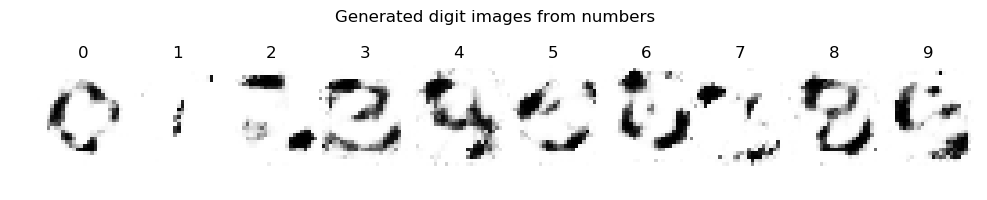

Accuracy: 0.8983


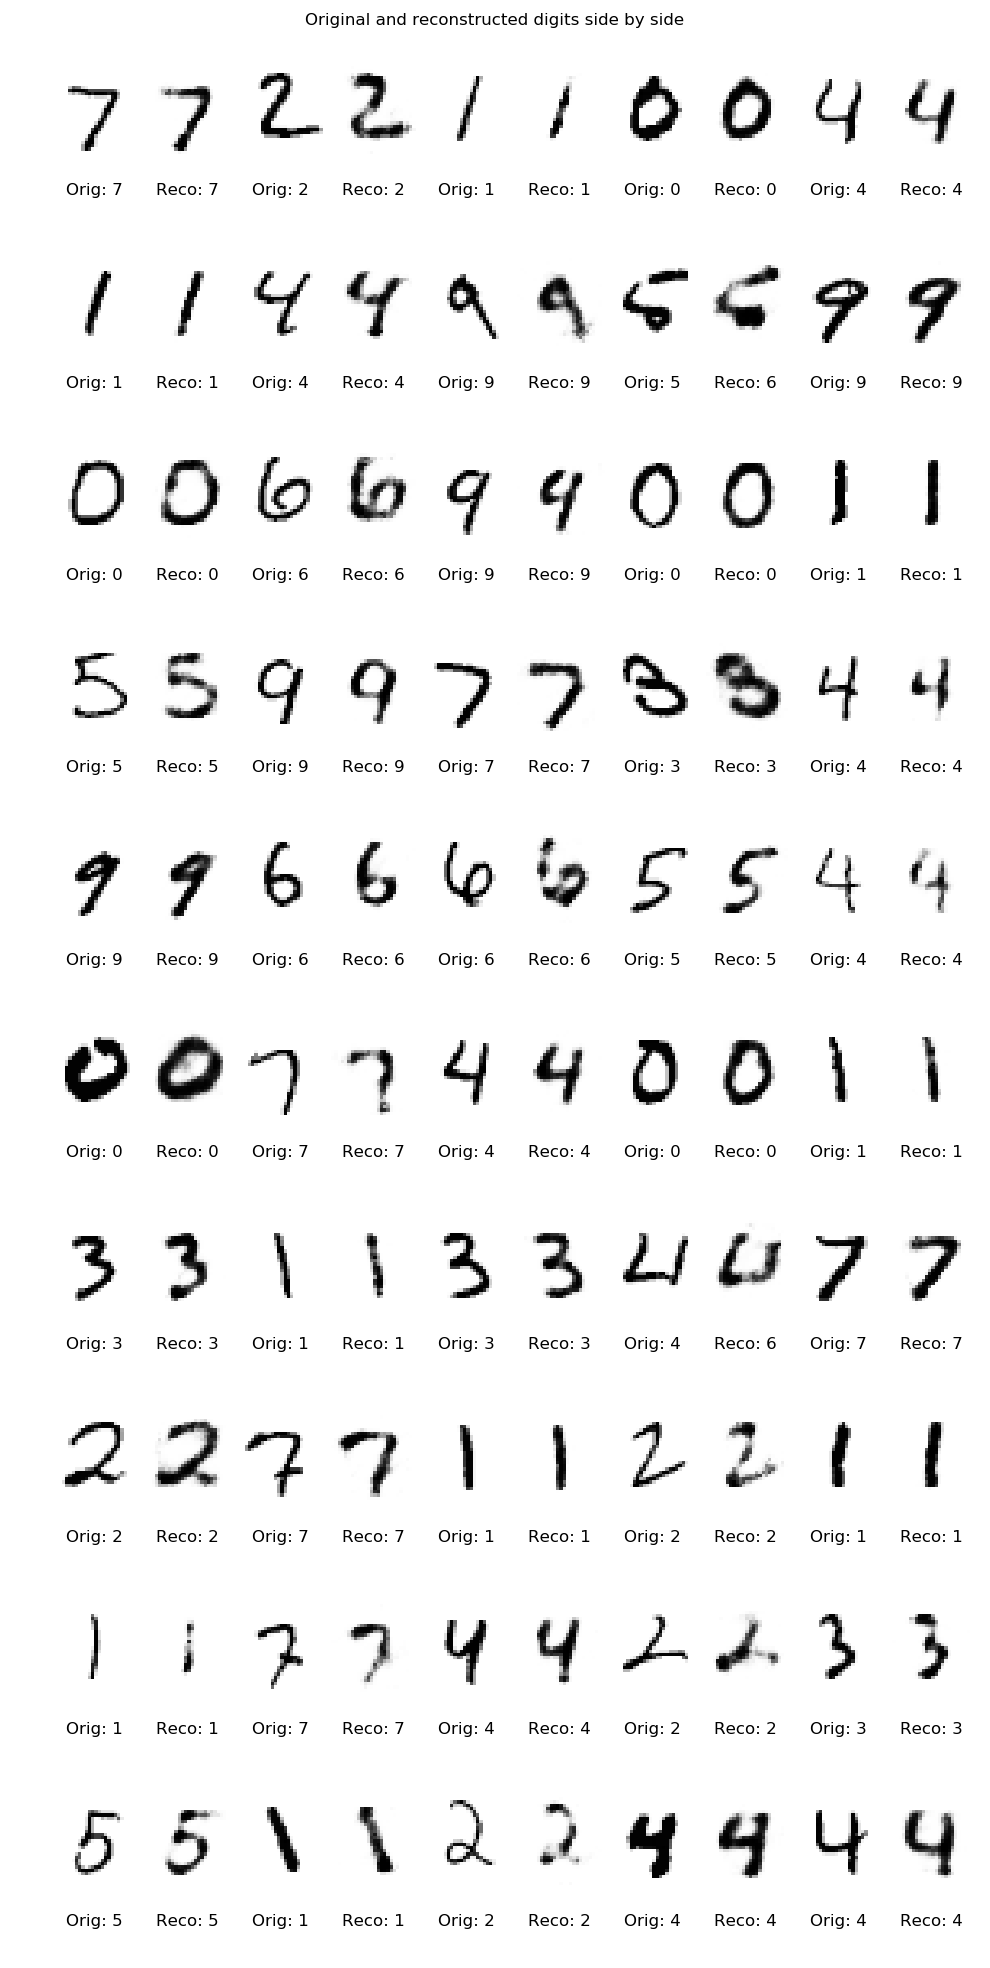

In [66]:

mnist = None
if __name__ == "__main__" and '__file__' not in globals():
    np.seterr(all='raise')
    mnist = MNIST_RBM()
    mnist.train()
    plt.close('all')
    mnist.generate()
    mnist.classify()

    